In [1]:
# notebook to make uncertainty in ignition delay plot

import os
import copy
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures
import rmgpy.chemkin
import pickle


import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# load base data

base_rmg7_1week = np.array([0.04830086, 0.04773837, 0.0462931 , 0.04678523, 0.07270171,
       0.07446053, 0.14525752, 0.14593983, 0.10720529, 0.09406754,
       0.0644564 , 0.05500488, 0.03497752, 0.02436985, 0.02310303,
       0.01383285])  # 1 week RMG model that completed - all 130 species
aramco7 = np.array([0.03945921, 0.03874611, 0.02817182, 0.02812066, 0.03236667,
       0.03278732, 0.06009581, 0.06085926, 0.06020536, 0.05459522,
       0.03965133, 0.03435827, 0.02245863, 0.01580939, 0.01499945,
       0.00896072])
experiment7 = np.array([0.0865 , 0.0739 , 0.0313 , 0.033  , 0.0309 , 0.03   , 0.056  ,
       0.0566 , 0.0679 , 0.0664 , 0.0652 , 0.0671 , 0.047  , 0.0279 ,
       0.02805, 0.012  ])


In [105]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
# ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)


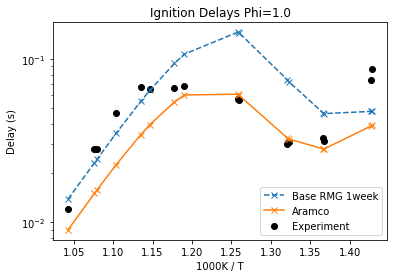

In [106]:
# plot the ignition delay
plt.plot(1000.0 / T7, base_rmg7_1week, marker='x', linestyle='dashed')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['Base RMG 1week', 'Aramco', 'Experiment'])
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

In [107]:
# get the mapping from cantera base back to RMG
# load the sensitive parameters
# chemkin = '/home/moon/autoscience/reaction_calculator/delay_uncertainty/base_rmg_1week/chem_annotated.inp'
chemkin = '/work/westgroup/harris.se/autoscience/reaction_calculator/delay_uncertainty/base_rmg_1week/chem_annotated.inp'
working_dir = os.path.dirname(chemkin)
transport = os.path.join(working_dir, 'tran.dat')
species_dict = os.path.join(working_dir, 'species_dictionary.txt')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin, dictionary_path=species_dict, transport_path=transport, use_chemkin_names=True)
cantera_file = os.path.join(working_dir, 'chem_annotated.cti')
base_gas = ct.Solution(cantera_file)
perturbed_cti_path = os.path.join(working_dir, 'perturbed.cti')
perturbed_gas = ct.Solution(perturbed_cti_path)


# Check that species order is preserved
for i in range(len(species_list)):
    assert str(species_list[i]) == base_gas.species_names[i]
    assert str(species_list[i]) == perturbed_gas.species_names[i]
    
# This cti -> rmg converter dictionary can be made using rmg_tools/ct2rmg_dict.py
with open(os.path.join(working_dir, 'ct2rmg_rxn.pickle'), 'rb') as handle:
    ct2rmg_rxn = pickle.load(handle)

# check that reaction order is also correct by comparing some random reactions
for i in [123, 837, 1500, 1800, 1955, 2002, 2303]:
    eq1 = ''.join(sorted(base_gas.reactions()[i].equation))
    eq2 = ''.join(sorted(str(reaction_list[ct2rmg_rxn[i]])))
    assert eq1 == eq2
    
    
N = len(base_gas.species())
M = len(base_gas.reactions())
assert N == 130
assert M == 2523

For species Ar, discontinuity in h/RT detected at Tmid = 4762.74
	Value computed using low-temperature polynomial:  2.327935178063383
	Value computed using high-temperature polynomial: 2.320328165487312

For species He, discontinuity in h/RT detected at Tmid = 4762.74
	Value computed using low-temperature polynomial:  2.327935178063383
	Value computed using high-temperature polynomial: 2.320328165487312

For species butane(1), discontinuity in h/RT detected at Tmid = 1389.0
	Value computed using low-temperature polynomial:  6.672352745666894
	Value computed using high-temperature polynomial: 6.314788936675075

For species CH(3), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  81.27192833333334
	Value computed using high-temperature polynomial: 81.30542726833333

For species C2H(4), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  79.04515833333333
	Value computed using high-temperature 

### Load Input Uncertainties $\Delta G$ and $\Delta \ln k$

In [45]:
# rxn_uncertainty_file = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/reaction_uncertainty.npy'
# sp_uncertainty_file = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/species_uncertainty.npy'

rxn_uncertainty_file = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/gao_reaction_uncertainty.npy'
sp_uncertainty_file = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/gao_species_uncertainty.npy'

rmg_rxn_uncertainty = np.load(rxn_uncertainty_file)
rmg_sp_uncertainty = np.load(sp_uncertainty_file)

assert len(rmg_rxn_uncertainty) == len(reaction_list)
assert len(rmg_sp_uncertainty) == len(species_list)


rxn_uncertainty = np.zeros(len(base_gas.reactions()))
for ct_index in range(len(rxn_uncertainty)):
    rxn_uncertainty[ct_index] = rmg_rxn_uncertainty[ct2rmg_rxn[ct_index]]

# Cantera species should be in same rmg order, but this makes sure for us
for i in range(len(species_list)):
    assert str(species_list[i]) == base_gas.species_names[i]

sp_uncertainty = rmg_sp_uncertainty

total_uncertainty_array = np.concatenate((sp_uncertainty, rxn_uncertainty), axis=0)
total_uncertainty_mat = np.repeat(np.transpose(np.matrix(total_uncertainty_array)), 12 * 51, axis=1)


### Load Sensitivity Coefficients $\frac{\partial \ln \tau}{\partial G}$ and $\frac{\partial \ln \tau}{\partial \ln k}$

In [53]:
# load the giant base delays matrix
base_delay_file = os.path.join(working_dir, 'total_base_delays.npy')
base_delays = np.load(base_delay_file)

# Load the giant delays matrix
total_delay_file = os.path.join(working_dir, 'total_perturbed_mech_delays.npy')
total_delays = np.load(total_delay_file)

assert total_delays.shape[1] == len(base_delays)

total_base_delays = np.repeat(np.matrix(base_delays), total_delays.shape[0], axis=0)
total_base_delays[total_base_delays == 0] = np.nan
assert total_base_delays.shape == total_delays.shape

total_delays[total_delays == 0] = np.nan

d_ln_tau = np.log(total_delays) - np.log(total_base_delays)

In [103]:
# get the change in enthalpy or reaction rate

phi_dicts = []

for table_index in range(1, 13):
    
    # Load the experimental conditions
    ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
    # ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
    df_exp = pd.read_csv(ignition_delay_data)
    table_exp = df_exp[df_exp['Table'] == table_index]
    # Define Initial conditions using experimental data
    tau_exp = table_exp['time (ms)'].values.astype(float)  # ignition delay
    T7 = table_exp['T_C'].values  # Temperatures
    P7 = table_exp['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
    phi7 = table_exp['phi'].values  # equivalence ratios
    # list of starting conditions
    # Mixture compositions taken from table 2 of
    # https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
    concentrations = []
    # for phi = 1
    x_diluent = 0.7649
    conc_dict = {
        'O2(2)': 0.2038,
        'butane(1)': 0.03135
    }

    
    x_N2 = table_exp['%N2'].values[0] / 100.0 * x_diluent
    x_Ar = table_exp['%Ar'].values[0] / 100.0 * x_diluent
    x_CO2 = table_exp['%CO2'].values[0] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    
    phi_dicts.append(conc_dict)
        
        

In [55]:
# There are 12 * K different simulation settings. We need each parameter estimate at each setting
# Create a matrix with temperatures and one with pressures
T = np.linspace(663, 1077, 51)
table_temperatures = np.repeat(np.matrix(T), 12, axis=1)
temperatures = np.repeat(table_temperatures, total_delays.shape[0], axis=0)

pressures = np.zeros(temperatures.shape)
for i in range(pressures.shape[1]):
    if int(i / 51) in [0, 3, 6, 9]:
        pressures[:, i] = 10.0 * 101325.0
    elif int(i / 51) in [1, 4, 7, 10]:
        pressures[:, i] = 20.0 * 101325.0
    elif int(i / 51) in [2, 5, 8, 11]:
        pressures[:, i] = 30.0 * 101325.0

In [68]:
G_base = np.zeros((N, total_delays.shape[1]))
G_perturbed = np.zeros((N, total_delays.shape[1]))


# get base G values

mod_gas = ct.Solution(cantera_file)
for j in range(N):
    for i in range(temperatures.shape[1]):
    
        T = temperatures[0, i]
        base_gas.TPX = T, pressures[0, i], phi_dicts[int(i / 51)]
        G_base[j, i] = base_gas.species()[j].thermo.h(T) - T * base_gas.species()[j].thermo.s(T)


In [70]:
# Get perturbed G values
# we confirmed that species order is preserved even between base and perturbed gases
mod_gas = ct.Solution(cantera_file)
for j in range(N):
#     print(j)
    # change just the one reaction
    mod_gas.modify_species(j, perturbed_gas.species()[j])
    
    for i in range(temperatures.shape[1]):
    
        T = temperatures[0, i]
        mod_gas.TPX = T, pressures[0, i], phi_dicts[int(i / 51)]
        G_perturbed[j, i] = mod_gas.species()[j].thermo.h(T) - T * mod_gas.species()[j].thermo.s(T)

    mod_gas.modify_species(j, base_gas.species()[j])

For species Ar, discontinuity in h/RT detected at Tmid = 4762.74
	Value computed using low-temperature polynomial:  2.327935178063383
	Value computed using high-temperature polynomial: 2.320328165487312

For species He, discontinuity in h/RT detected at Tmid = 4762.74
	Value computed using low-temperature polynomial:  2.327935178063383
	Value computed using high-temperature polynomial: 2.320328165487312

For species butane(1), discontinuity in h/RT detected at Tmid = 1389.0
	Value computed using low-temperature polynomial:  6.672352745666894
	Value computed using high-temperature polynomial: 6.314788936675075

For species CH(3), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  81.27192833333334
	Value computed using high-temperature polynomial: 81.30542726833333

For species C2H(4), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  79.04515833333333
	Value computed using high-temperature 

For species C2H5O2(47), discontinuity in h/RT detected at Tmid = 1389.0
	Value computed using low-temperature polynomial:  9.956664416545813
	Value computed using high-temperature polynomial: 9.792960641216094

For species C2H6O2(48), discontinuity in h/RT detected at Tmid = 1390.0
	Value computed using low-temperature polynomial:  -1.9677150508723127
	Value computed using high-temperature polynomial: -2.1890157436045534

For species C2H5O(49), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  7.009500333333333
	Value computed using high-temperature polynomial: 6.85734259

For species C2H4O(51), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.29742900000000283
	Value computed using high-temperature polynomial: 0.13550459666666725

For species C2H3O3(56), discontinuity in h/RT detected at Tmid = 1393.0
	Value computed using low-temperature polynomial:  3.7899779742663924
	Value computed

For species C4H6(194), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  25.516044833333332
	Value computed using high-temperature polynomial: 25.249191016666668

For species C4H9O(198), discontinuity in h/RT detected at Tmid = 1392.0
	Value computed using low-temperature polynomial:  9.930607109940214
	Value computed using high-temperature polynomial: 9.54987024700578

For species S(200), discontinuity in h/RT detected at Tmid = 1399.0
	Value computed using low-temperature polynomial:  -0.5330225093028069
	Value computed using high-temperature polynomial: -0.9176177950578328

For species C4H7O(202), discontinuity in h/RT detected at Tmid = 1395.0
	Value computed using low-temperature polynomial:  22.488181349087316
	Value computed using high-temperature polynomial: 22.08819255065596

For species C4H8O(214), discontinuity in h/RT detected at Tmid = 1371.0
	Value computed using low-temperature polynomial:  6.69776039237299
	Value computed

For species S(4243), discontinuity in h/RT detected at Tmid = 1059.17
	Value computed using low-temperature polynomial:  24.58786528757453
	Value computed using high-temperature polynomial: 24.272786296453965

For species S(4244), discontinuity in h/RT detected at Tmid = 1310.93
	Value computed using low-temperature polynomial:  25.65129342782523
	Value computed using high-temperature polynomial: 25.51680333864407

For species C4H7(4343), discontinuity in h/RT detected at Tmid = 936.88
	Value computed using low-temperature polynomial:  43.23108488114937
	Value computed using high-temperature polynomial: 42.974074169338735

For species S(4407), discontinuity in h/RT detected at Tmid = 1493.99
	Value computed using low-temperature polynomial:  25.289221326036774
	Value computed using high-temperature polynomial: 25.170887720316664

For species C4H6(4880), discontinuity in h/RT detected at Tmid = 980.35
	Value computed using low-temperature polynomial:  72.68408493605675
	Value computed u

In [71]:
# In theory, delta G should be 10% G_base, but apparently it isn't...
# G has units Enthalpy [J/kg or J/kmol] it's J / kmol
delta_G = G_perturbed - G_base
delta_G_kcal_mol = delta_G / 4.184 / 1000.0 / 1000.0  # needs to be kcal/mol to match Gao paper

In [72]:
delta_G_kcal_mol

array([[-0.20887562, -0.20887562, -0.20887562, ..., -0.20887562,
        -0.20887562, -0.20887562],
       [-0.14804672, -0.14804672, -0.14804672, ..., -0.14804672,
        -0.14804672, -0.14804672],
       [-0.14804672, -0.14804672, -0.14804672, ..., -0.14804672,
        -0.14804672, -0.14804672],
       ...,
       [-6.88842596, -6.88842596, -6.88842596, ..., -6.88842596,
        -6.88842596, -6.88842596],
       [-3.91657253, -3.91657253, -3.91657253, ..., -4.08513117,
        -4.08513117, -4.08513117],
       [-1.51777238, -1.51777238, -1.51777238, ..., -1.51777238,
        -1.51777238, -1.51777238]])

In [73]:
# Now get reaction rate change d ln(k), but this was chosen to be 0.1

delta_ln_k = 0.1 * np.ones((M, total_delays.shape[1]))

In [74]:
# concatenate into a big delta matrix
delta = np.concatenate((delta_G_kcal_mol, delta_ln_k), axis=0)

In [76]:
# first derivative is change in delay / change in G or change in delay / change in ln k
first_derivative = np.divide(d_ln_tau, delta)

In [77]:
first_derivative_squared = np.float_power(first_derivative, 2.0)

In [88]:
total_id_uncertainty = np.ravel(np.nansum(np.multiply(first_derivative_squared, total_uncertainty_mat), axis=0))

In [89]:
total_id_uncertainty

array([1.39033937, 1.49897606, 1.65234393, 1.87896878, 2.21455319,
       2.6675219 , 3.33664727, 4.27015677, 5.46289334, 6.82918126,
       8.19008806, 9.28040828, 9.74735355, 9.20746117, 7.61966289,
       5.58049887, 3.83111458, 2.60756855, 1.80722285, 1.28785253,
       0.94786768, 0.72349402, 0.5754285 , 0.47906827, 0.41859812,
       0.38355973, 0.36685931, 0.36358357, 0.37027767, 0.38448915,
       0.40447481, 0.42900506, 0.45723127, 0.48859871, 0.52277785,
       0.55962591, 0.59916644, 0.64165223, 0.68776775, 0.73946401,
       0.80449757, 0.94523812, 0.99013098, 1.03213381, 1.06991595,
       1.10215015, 1.12761275, 1.14530514, 1.15451867, 1.15493199,
       1.14663665, 1.25604048, 1.26170327, 1.25456048, 1.25739403,
       1.27346383, 1.30806664, 1.36945243, 1.47020138, 1.62801858,
       1.86621994, 2.21151832, 2.68842105, 3.30923393, 4.06138316,
       4.8954089 , 5.71765058, 6.38577003, 6.70100111, 6.42925764,
       5.47659157, 4.16724193, 2.98935549, 2.1311825 , 1.55382

In [90]:
total_id_uncertainty.shape

(612,)

In [159]:
total_base_delays

matrix([[0.10237338, 0.08290546, 0.06856396, ..., 0.00100567, 0.00091873,
         0.00084197],
        [0.10237338, 0.08290546, 0.06856396, ..., 0.00100567, 0.00091873,
         0.00084197],
        [0.10237338, 0.08290546, 0.06856396, ..., 0.00100567, 0.00091873,
         0.00084197],
        ...,
        [0.10237338, 0.08290546, 0.06856396, ..., 0.00100567, 0.00091873,
         0.00084197],
        [0.10237338, 0.08290546, 0.06856396, ..., 0.00100567, 0.00091873,
         0.00084197],
        [0.10237338, 0.08290546, 0.06856396, ..., 0.00100567, 0.00091873,
         0.00084197]])

In [95]:
np.ravel(total_base_delays[0,:])

array([0.10237338, 0.08290546, 0.06856396, 0.05814131, 0.05082041,
       0.04608224, 0.04364232, 0.04341952, 0.04552189, 0.05024511,
       0.05805369, 0.06948789, 0.08484429, 0.10339567, 0.12243015,
       0.13773631, 0.14622927, 0.14757541, 0.14312505, 0.13465996,
       0.12380001, 0.11181526, 0.09961749, 0.08781575, 0.07678491,
       0.06672823, 0.05772858, 0.04978816, 0.04285839, 0.03686144,
       0.03170533, 0.02729403, 0.02353378, 0.0203369 , 0.01762367,
       0.01532306, 0.01337277, 0.01171871, 0.01031434, 0.00911988,
       0.00810148, 0.00723052, 0.00648278, 0.00583795, 0.00527898,
       0.00479161, 0.00436395, 0.00398614, 0.00364999, 0.00334879,
       0.00307702, 0.05836062, 0.04563083, 0.03613375, 0.02899306,
       0.02359263, 0.0194957 , 0.01639104, 0.01405685, 0.01233621,
       0.01112068, 0.01033921, 0.00995105, 0.00994157, 0.0103196 ,
       0.01111517, 0.01237428, 0.01414408, 0.0164332 , 0.01912542,
       0.02186381, 0.0240933 , 0.02539924, 0.02570554, 0.02515

In [160]:
i

18

In [158]:
total_base_delays[0, (i - 1) * K: i*K]

matrix([], shape=(1, 0), dtype=float64)

(0.002535634068872223, 0.1790845670208614)

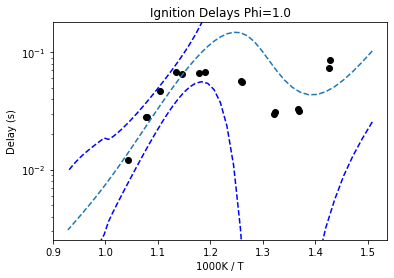

In [177]:
# extract table 7
table_index = 7


# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
# ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == table_index]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)



K = 51
table7_uncertainty = total_id_uncertainty[(table_index - 1) * K: table_index * K]
table7_delay_times = np.ravel(total_base_delays[0, (table_index - 1) * K: table_index*K])
Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
Tmin = 663
temperatures = np.linspace(Tmin, Tmax, K)

upper_bound = np.exp(np.log(table7_delay_times) + table7_uncertainty)
lower_bound = np.exp(np.log(table7_delay_times) - table7_uncertainty)


# plot the ignition delay
plt.plot(1000.0 / temperatures, table7_delay_times, linestyle='dashed')
# plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
plt.plot(1000.0 / temperatures, lower_bound, linestyle='dashed', color='blue')
plt.plot(1000.0 / temperatures, upper_bound, linestyle='dashed', color='blue')
ax = plt.gca()
ax.set_yscale('log')
# plt.legend(['Base RMG 1week', 'Aramco', 'Experiment'])
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

plt.ylim([0.002535634068872223, 0.1790845670208614])

In [176]:
ax.get_ylim()

(0.002535634068872223, 0.1790845670208614)